# Standardized nutrient analysis of global fisheries

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import theano.tensor as tt
from pymc3.backends import SQLite
import seaborn as sns
import scipy as sp
import pdb

In [2]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Helper functions
def indexall_B(L,B):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    a, b = poo.index(B), 0
    poo[b], poo[a] = poo[a], poo[b]
    
    Ix[Ix==b] = -1
    Ix[Ix==a] = 0
    Ix[Ix==-1] = a
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))


# Coefficient of variation
cv =  lambda x: np.var(x) / np.mean(x)

## Import data

In [3]:
# Nutritional data
ndata = pd.read_excel('Nutrient_data.xlsx')
# Traits data
tdata = pd.read_excel('Traits_all.xlsx')

In [4]:
# Add traits information to nutritional dataframe
indx = match(ndata.Species_from_search.unique(),list(tdata.species_traits_all.values))
rindx = match(ndata.Species_from_search,list(ndata.Species_from_search.unique()))

# Traits to port over
tmp = ['Class', 'Order', 'Family','Genus_1', 'DemersPelag',
       'EnvTemp', 'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm']
# Port over
for trait in tmp:
    ndata[trait] = tdata[trait].values[indx][rindx]

ndata.head()

,ID_no,Species_from_search,Protein_Replicates,Protein_Value_perc,Protein_Variance,Zn_Replicates,Zn_Value,Zn_Variance,Ca_Replicates,Ca_Value,...,Genus_1,DemersPelag,EnvTemp,DepthRangeDeep,trophic_level,Feeding_path,LMax,BodyShapeI,K,tm
0,A_3,Merluccius_merluccius,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Merluccius,demersal,temperate,1075.0,4.40,pelagic,140.0,elongate,0.148,4.199469
1,A_4,Scomber_scombrus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.262,2.636997
2,A_38,Scomber_scombrus,NaN,NaN,NaN,11,0.8090,NaN,NaN,NaN,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.262,2.636997
3,A_39,Merluccius_gayi_gayi,NaN,NaN,NaN,11,0.1787,NaN,NaN,NaN,...,Merluccius,pelagic_oceanic,polar_deep,500.0,4.26,pelagic,87.0,fusiform,0.120,5.100000
4,A_40,Engraulis_encrasicolus,NaN,NaN,NaN,11,0.7041,NaN,NaN,NaN,...,Engraulis,pelagic_neritic,subtropical,400.0,3.12,pelagic,20.0,elongate,1.000,1.000000


### Datasets

In [5]:
Nutrients = ['Protein', 'Zinc', 'Iron', 'Calcium', 'Omega3', 'Vitamin_A', 'Selenium']
Nkeys = ['Protein_Value_perc', 'Zn_Value', 'Fe_Value', 'Ca_Value', 'O3_Value', 'VitA_Value', 'Se_Value']
nnutrients = len(Nutrients)

## ======= Change nutrient here & likelihood below ========= #

In [6]:
# Change this number to run model on specific nutrient
i = 6
nut = Nutrients[i]
nut

'Selenium'

In [7]:
# Response
var = Nkeys[i]
Y_ = ndata[var].values
# Filter
indx = np.isnan(Y_)==False
Y = np.log(Y_[indx]+1)
# Filter dataframe
tmpdata = ndata[indx]

Order,Io = indexall(tmpdata.Order.values)
nord = len(Order)

# Covariates
Habitat,Ih = indexall_B(tmpdata['DemersPelag'].values, 'demersal')
nhabs = len(Habitat)
Climate,Ic = indexall_B(tmpdata['EnvTemp'].values, 'temperate')
nclim = len(Climate)
MaxDepth = stdize(np.log(tmpdata['DepthRangeDeep'].values))
TL = stdize(tmpdata['trophic_level'].values)
Pelagic = tmpdata['Feeding_path'].values=="pelagic"
LMax = stdize(np.log(tmpdata['LMax'].values))
Body,Ib = indexall_B(tmpdata['BodyShapeI'].values, 'fusiform')
nbod = len(Body)
K = stdize(tmpdata['K'].values)
tm = stdize(np.log(tmpdata['tm'].values))

# Nussiance parameters
Form,If = indexall_B(tmpdata['Form_Clean'].values, 'muscle')
nform = len(Form)
Prep,Ip = indexall_B(tmpdata['Prep'].values, 'wet')
nprep = len(Prep)
Search,Is = indexall_B(tmpdata['Search'].values, 'WOS')
nsearch = len(Search)

In [8]:
Model_1 = pm.Model()

with Model_1:
    # Intercept
    γ0 = pm.Normal('Intercept', mu=0, tau=0.0001)
    # Observation model
    σγ = pm.Uniform('Sigma_γ', lower=0, upper=1000)
    β0 = pm.Normal('Order', mu=γ0, sd=σγ, shape=nord)
    
    
    #"""
    # Habitat type
    β1_ = pm.Normal('Habitat', 0, tau=0.01, shape=nhabs-1)
    β1 = tt.set_subtensor(tt.zeros(shape=nhabs)[1:], β1_)
    # Climate
    β2_ = pm.Normal('Climate', 0, tau=0.01, shape=nclim-1)
    β2 = tt.set_subtensor(tt.zeros(shape=nclim)[1:], β2_)
    # Maximum Depth
    β3 = pm.Normal('MaxDepth', 0, tau=0.01)
    # Total Length
    β4 = pm.Normal('TL', 0, tau=0.01)
    # Pelagic/demersal
    β5 = pm.Normal('pelagic', 0, tau=0.01)
    # Maximum length
    β6 = pm.Normal('LMax', 0, tau=0.01)
    # Body form
    β7_ = pm.Normal('Body', 0, tau=0.01, shape=nbod-1)
    β7 = tt.set_subtensor(tt.zeros(shape=nbod)[1:], β7_)
    # Growth parameter
    β8 = pm.Normal('K', 0, tau=0.01)
    # Age at maturity
    β9 = pm.Normal('tm', 0, tau=0.01)
    
    # Form of sample
    β10_ = pm.Normal('Form', 0, tau=0.01, shape=nform-1)
    β10 = tt.set_subtensor(tt.zeros(shape=nform)[1:], β10_)
    # Form of prepartion
    β11_ = pm.Normal('Prep', 0, tau=0.01, shape=nprep-1)
    β11 = tt.set_subtensor(tt.zeros(shape=nprep)[1:], β11_)
    # Database used
    β12_ = pm.Normal('Search', 0, tau=0.01, shape=nsearch-1)
    β12 = tt.set_subtensor(tt.zeros(shape=nsearch)[1:], β12_)
    
    #"""
    
    # Mean model
    μ_ = β0[Io]+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    
    # Normal - Calcium (3), Omega-3 (4), Vitamin-A (5), Selenium (6)
    μ = μ_
    σ = pm.Uniform('Sigma', lower=0, upper=1000)
    Yi = pm.Normal('Yi', mu=μ, sd=σ, observed=Y)
    
    # ST - Protein (0)
    #μ = μ_
    #ν = pm.Uniform('nu', lower=0, upper=4)
    #σ = pm.Uniform('Sigma', lower=0, upper=1000)
    #Yi = pm.StudentT('Yi', nu=ν, mu=μ, sd=σ, observed=Y)
    
    # Gamma model - Zinc (1), Iron (2)
    #μ = tt.exp(μ_)
    #α = pm.Uniform('α', lower=0., upper=100.)
    #Yi = pm.Gamma('Yi', alpha=α, beta=α/μ, observed=Y)
    

In [9]:
# Sampling
with Model_1:
    # Draw samples
    trace = pm.sample(5000, progressbar=True,  njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Sigma, Search, Prep, Form, tm, K, Body, LMax, pelagic, TL, MaxDepth, Climate, Habitat, Order, Sigma_γ, Intercept]
Sampling 2 chains: 100%|██████████| 11000/11000 [01:21<00:00, 134.53draws/s]
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
There were 417 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


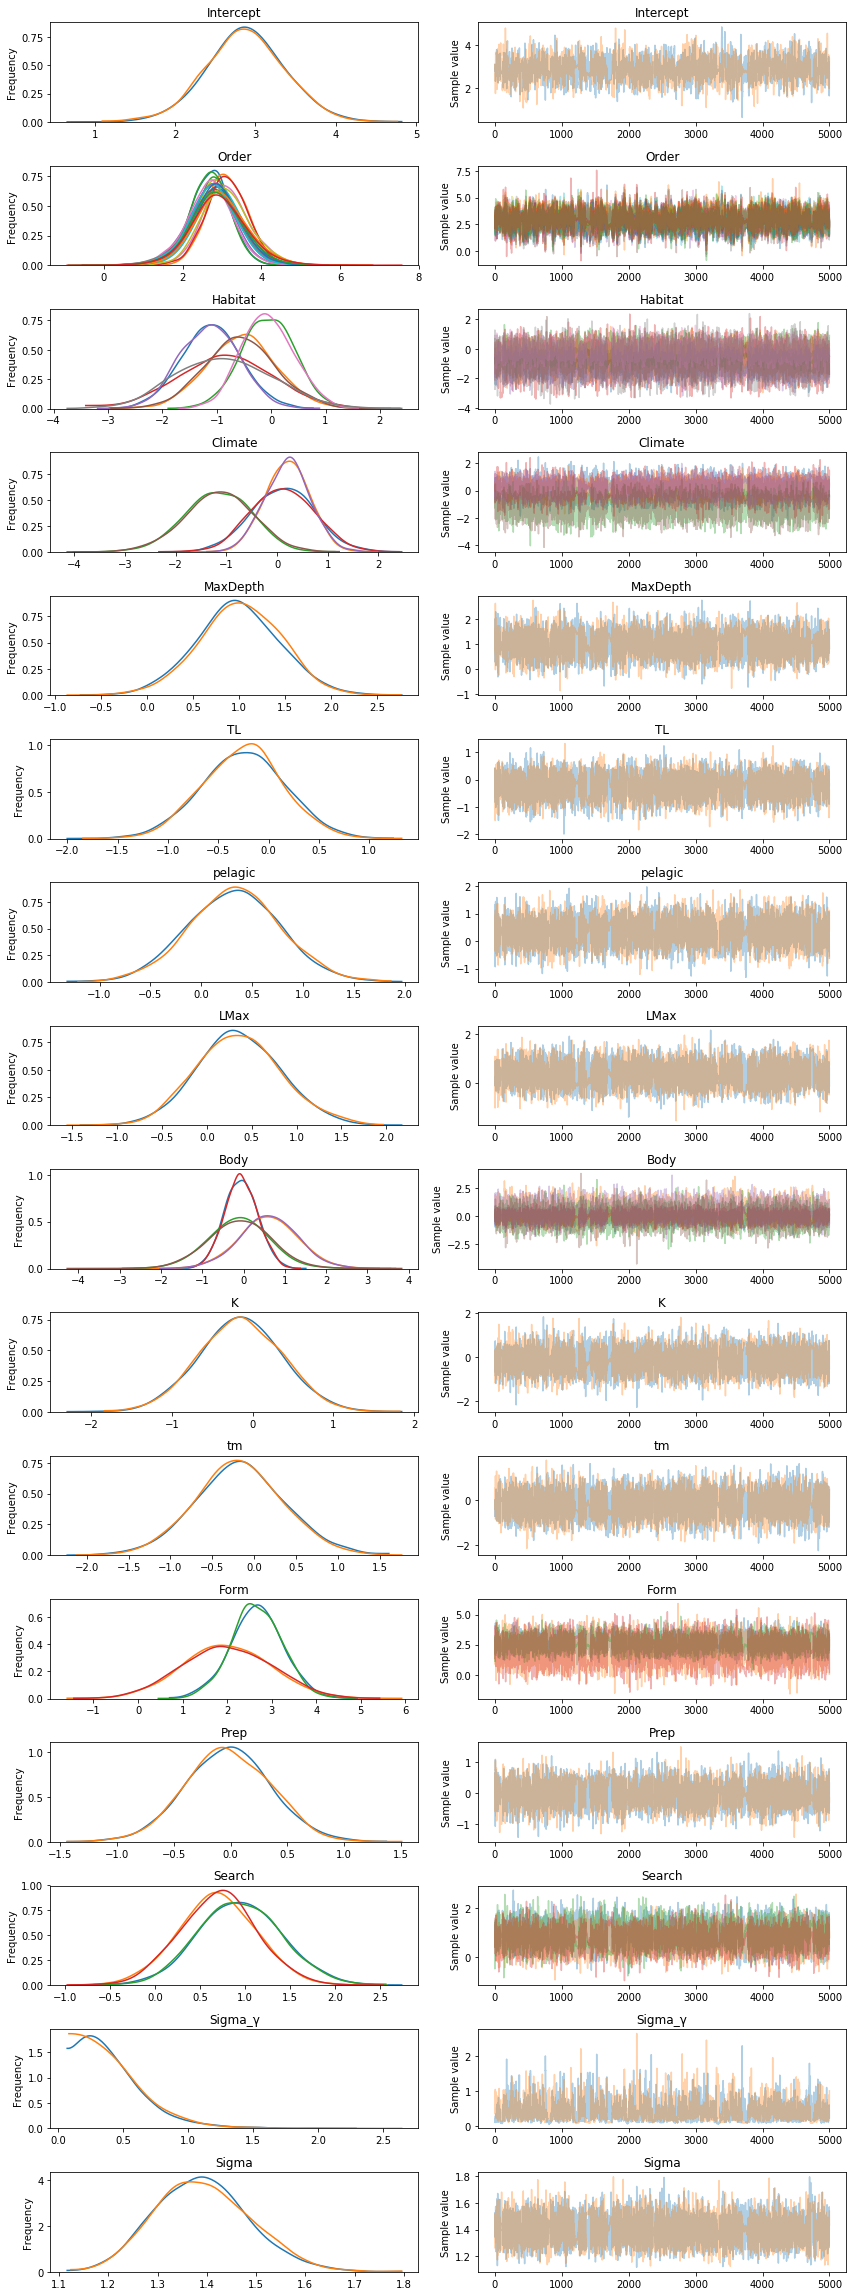

In [10]:
pm.traceplot(trace)
plt.savefig('Figure_S2_'+nut+'_std.jpg',dpi=300);

In [11]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,2.881704,0.485220,0.013248,1.918527,3.830071,1380.072311,1.000245
Order__0,2.701100,0.493367,0.011396,1.700913,3.643129,1849.247816,1.000236
Order__1,3.125598,0.509944,0.014256,2.130154,4.105776,1188.023838,1.000020
Order__2,2.841962,0.559339,0.013954,1.783420,4.009819,1649.646563,0.999945
Order__3,2.815103,0.646897,0.013962,1.515558,4.108171,2394.309511,1.000095
Order__4,2.695993,0.583834,0.012514,1.457894,3.785000,2169.808407,1.000403
Order__5,2.801914,0.654896,0.014861,1.460389,4.104614,2121.606560,1.000456
Order__6,3.114906,0.599111,0.014986,2.024361,4.388480,1505.508010,0.999979
Order__7,2.775896,0.599151,0.013167,1.500531,3.901332,2189.476373,1.000012
Order__8,2.875716,0.580813,0.013527,1.687460,4.027935,1971.993220,0.999914


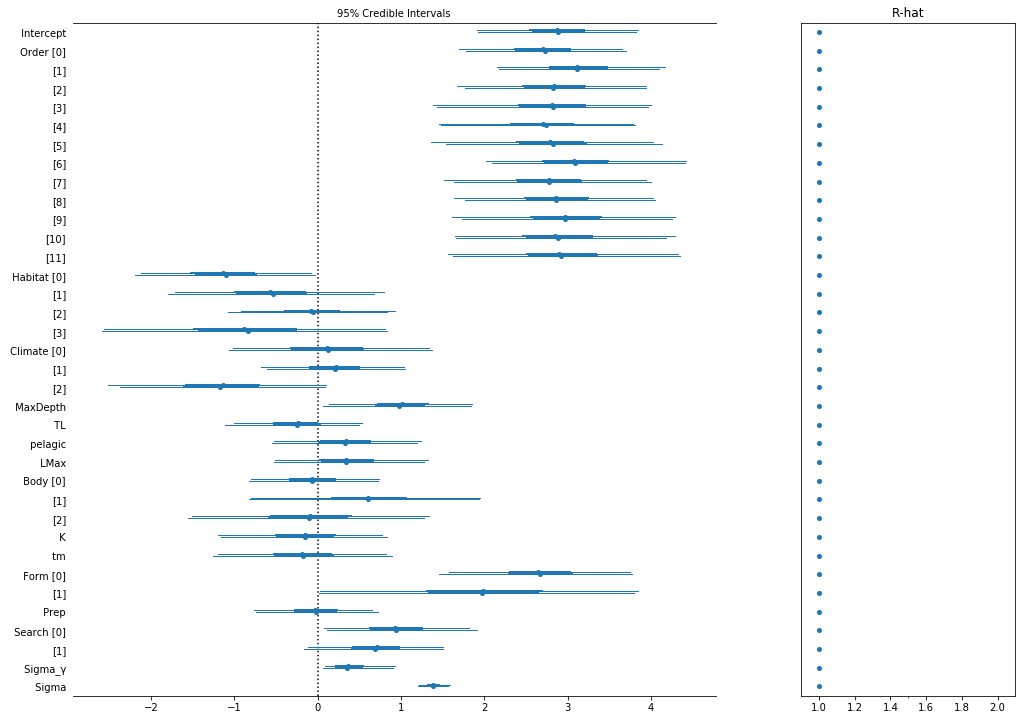

In [12]:
plt.figure(figsize=(17, 11))
pm.forestplot(trace)
plt.savefig('Figure_S3_'+nut+'_std.jpg',dpi=300);

In [13]:
# Export results 
out = pm.backends.tracetab.trace_to_dataframe(trace)
colnames = np.array(list(out.columns), dtype=object)
# Rename columns
colnames[match(grep('Habitat',list(colnames)),list(colnames))] = Habitat[1:]
colnames[match(grep('Climate',list(colnames)),list(colnames))] = Climate[1:]
colnames[match(grep('Body',list(colnames)),list(colnames))] = Body[1:]
colnames[match(grep('Form',list(colnames)),list(colnames))] = Form[1:]
colnames[match(grep('Prep',list(colnames)),list(colnames))] = Prep[1:]
colnames[match(grep('Search',list(colnames)),list(colnames))] = Search[1:]
# Rename
out.columns = list(colnames)

In [14]:
# Add baseline columns to dataframe
out['demersal'] = 0
out['temperate'] = 0
out['fusiform'] = 0
out['muscle'] = 0
out['wet'] = 0
out['WOS'] = 0

In [15]:
out.to_csv(Nutrients[i]+'_std_results.csv')

### Model-checking

In [16]:
ppc = pm.sample_ppc(trace, model=Model_1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 10000/10000 [00:10<00:00, 954.89it/s]


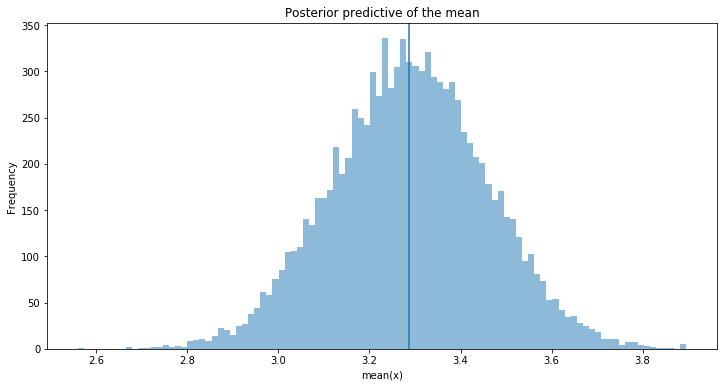

In [17]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in ppc['Yi']], bins=100, alpha=0.5)
ax.axvline(Y.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency')
plt.savefig('Figure_S4_'+nut+'_std.jpg',dpi=300);

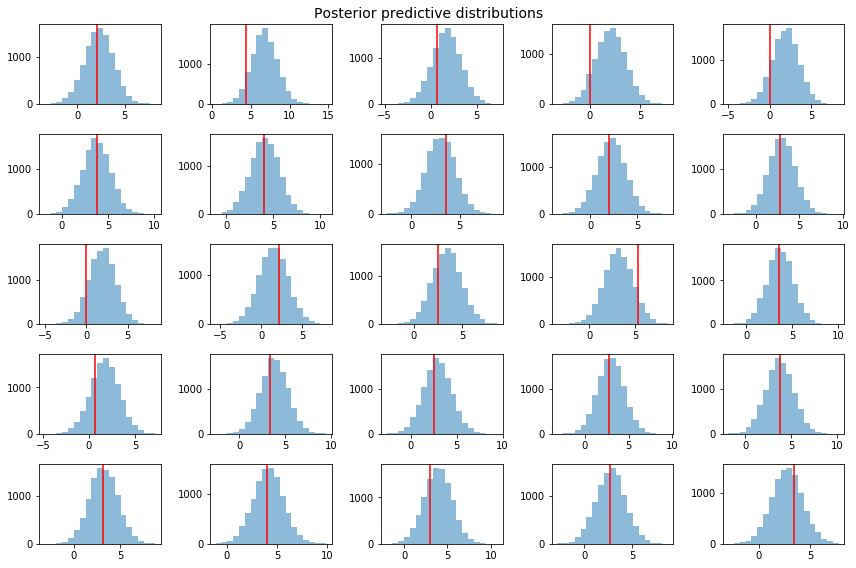

In [18]:
# Setup multipanel figure
nrows, ncols = 5, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8))
ax_ = axes.flatten()

# Transform ppc
PPC = ppc['Yi'].T
# Index random observations
indx = np.random.randint(0,len(PPC),size=nrows*ncols)

# Iterate over random samples from ppc
for i in range(nrows*ncols):
    ax1 = ax_[i]
    ax1.hist(PPC[indx[i]], bins=19, alpha=0.5)
    ax1.axvline(Y[indx[i]],c='red')

fig.tight_layout()
fig.suptitle('Posterior predictive distributions', fontsize=14)
fig.subplots_adjust(top=0.95)
plt.savefig('Figure_S5_'+nut+'_std.jpg',dpi=300);